# Shopee Product Classification 

Notebook to experiment over several Neural Networks over the product dataset obtained from Shopee and evaluate results.

The following models are evaluated as part of this notebook:

Baseline 1: CNN <br>
Baseline 2: CNN with augmented layers <br>
Improvement 1: Adding RNN <br>
Improvement 2: Adding attention

## Imports and Config

In [39]:
!pip install scikit-image
!pip install shopee_crawler
!pip install torchvision
!pip install opencv-python

You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\shubh\.pyenv\pyenv-win\versions\3.7.9\python.exe -m pip install --upgrade pip' command.


In [51]:
# System
import os
import sys
import json
import importlib
from tqdm import tqdm

# Data
import numpy as np
import pandas as pd

# Visualization
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Custom Modules
from scripts import crawler
from utils import file_utils, device_utils
from model import trainer, dataset, baseline_cnn_1


import cv2
import torch
import torch.nn as nn
from torchvision.models import ResNet18_Weights
from torchvision import transforms, models, datasets

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score

In [52]:
# Can use this to reload file when editing for faster changes (Will remove when finally submitting)
importlib.reload(baseline_cnn_1)

<module 'model.baseline_cnn_1' from 'C:\\Users\\shubh\\Desktop\\NUS\\Semester Two\\Neural Networks I\\cs5242-project\\model\\baseline_cnn_1.py'>

## Data Load

In [7]:
image_dir = 'data/images'

In [8]:
if(file_utils.check_images_dir()):
    print(f'Images already exist at: {file_utils.images}')
elif(file_utils.check_tar_exists()):
    print(f'Images not yet extracted')
    print(f'Image zip exists at: {file_utils.images_zip}')
    file_utils.extract_tar()
else:
    print(f'Images need to be downloaded')
    for c in category_urls:
        get_category_data('data', c)
    download_images('data')

Images already exist at: data/images


## Note: To be in accordance with other folders, changes to make:
- Add "-cat" to Women's Apparel directory after unzipping (Maybe we handle when we're zipping itself? Otherwise we can add a condition for this in the dataloader too)

## Dataset

In [9]:
data = dataset.DataSet(max_num_img=300)

<BarContainer object of 24 artists>

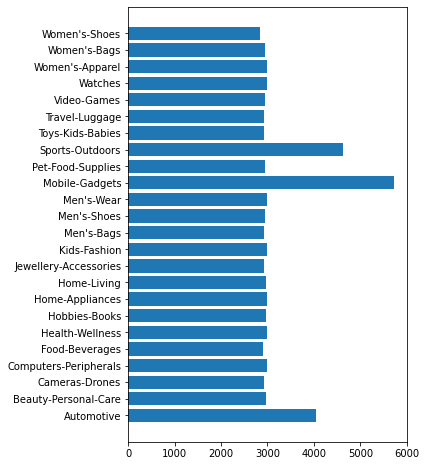

In [10]:
cats, items = zip(*data.image_count_per_category().items())
fig, ax = plt.subplots(figsize=(5, 8))
ax.barh(cats, items)

In [11]:
data.load_all()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 304.40it/s]


In [12]:
all_categories = data.categories
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: data.plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=('Automotive', 'Beauty-Personal-Care', 'Cameras…

## Model Configurations

In [45]:
batch_size = 32
num_epoch = 10

device = device_utils.get_device()

## Pretrained Model

In [19]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [21]:
trainer = trainer.Trainer(model, optimizer, criterion, data, batch_size)
trainer.run_train(num_epoch)

epoch   0 |   100 batches loss: 4.2970
epoch   0 |   200 batches loss: 2.9997


KeyboardInterrupt: 

In [19]:
test_loss, test_acc, incorect_stats = trainer.run_test(trainer.testloader, True)
print(f'Accuracy of the network on the test images: {test_acc*100} %')

Accuracy of the network on the test images: 29.65277777777778 %


In [22]:
from collections import Counter

counts = Counter(incorect_stats).most_common(25)
for k, v in counts:
    print(f"({all_categories[k[0]]}, {all_categories[k[1]]}): {v}")

(Health-Wellness, Food-Beverages): 17
(Women's-Bags, Men's-Bags): 10
(Hobbies-Books, Food-Beverages): 10
(Mobile-Gadgets, Computers-Peripherals): 9
(Home-Living, Food-Beverages): 8
(Toys-Kids-Babies, Kids-Fashion): 8
(Women's-Apparel, Kids-Fashion): 8
(Cameras-Drones, Home-Appliances): 7
(Computers-Peripherals, Men's-Bags): 7
(Health-Wellness, Pet-Food-Supplies): 7
(Pet-Food-Supplies, Food-Beverages): 7
(Automotive, Home-Appliances): 7
(Beauty-Personal-Care, Health-Wellness): 7
(Travel-Luggage, Women's-Bags): 7
(Automotive, Women's-Bags): 7
(Home-Appliances, Computers-Peripherals): 7
(Home-Living, Computers-Peripherals): 7
(Automotive, Home-Living): 7
(Computers-Peripherals, Mobile-Gadgets): 7
(Travel-Luggage, Men's-Bags): 6
(Men's-Bags, Women's-Bags): 6
(Jewellery-Accessories, Travel-Luggage): 6
(Home-Living, Jewellery-Accessories): 6
(Women's-Shoes, Watches): 6
(Women's-Shoes, Men's-Shoes): 6


## CNN Baseline Model

In [53]:
baseline_cnn_1_model = baseline_cnn_1.BaselineCNN1(len(data.categories))
baseline_cnn_1_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_cnn_1_model.parameters(), lr=0.0005)

In [54]:
trainer = trainer.Trainer(baseline_cnn_1_model, optimizer, criterion, data, batch_size)
trainer.run_train(num_epoch)

epoch   0 |   100 batches loss: 3.1785
[Epoch   0]: Training loss: 3.162832 | Accuracy: 0.051587
[Epoch   0]: Validation loss: 3.092077 | Accuracy: 0.072222
epoch   1 |   100 batches loss: 3.0838
[Epoch   1]: Training loss: 3.075775 | Accuracy: 0.072421
[Epoch   1]: Validation loss: 3.064136 | Accuracy: 0.083333
epoch   2 |   100 batches loss: 3.0609
[Epoch   2]: Training loss: 3.061739 | Accuracy: 0.075794
[Epoch   2]: Validation loss: 3.032888 | Accuracy: 0.075000
epoch   3 |   100 batches loss: 3.0425
[Epoch   3]: Training loss: 3.046361 | Accuracy: 0.082540
[Epoch   3]: Validation loss: 3.041433 | Accuracy: 0.088889
epoch   4 |   100 batches loss: 3.0328
[Epoch   4]: Training loss: 3.033090 | Accuracy: 0.089683
[Epoch   4]: Validation loss: 3.024935 | Accuracy: 0.104167
epoch   5 |   100 batches loss: 3.0035
[Epoch   5]: Training loss: 3.007412 | Accuracy: 0.098214
[Epoch   5]: Validation loss: 3.003448 | Accuracy: 0.104167
epoch   6 |   100 batches loss: 2.9621
[Epoch   6]: Traini

KeyboardInterrupt: 